## Let's understand the data behind the meme through analysis of the cards
https://preview.redd.it/me-whos-trying-to-get-back-to-the-game-v0-02xzy4rnqycb1.jpg?width=640&crop=smart&auto=webp&s=c93b16f6372b8bb023d8c866757cb91192983629

Most players or previous player of the game can tell you that it's not what it used to be "back in the day". 

We can find how the official rules have changed [online](http://https://yugioh.fandom.com/wiki/TCG_Rule_Changes) for example in 2008.

But what we are insterrested here is how the cards themselves and their current playability have impacted the game.

For example through their special effects in Chains.

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
print("Setup Complete")

Setup Complete


In [2]:
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#Loading the data
cards_filepath = "/kaggle/input/yugioh-cards/cards.csv"
cards_data = pd.read_csv(cards_filepath)

In [4]:
# Replace inf and -inf with NaN explicitly
cards_data = cards_data.replace([np.inf, -np.inf], np.nan)

In [5]:
#Looking for empty cells in each column
missing_values_count = cards_data.isnull().sum()
missing_values_count[0:29]

id                     0
name                   0
type                   0
desc                   0
atk                 4650
def                 5065
level               5065
race                   1
attribute           4650
scale              12933
archetype           5493
linkval            12866
linkmarkers        12866
image_url              0
image_url_small        0
ban_tcg            13086
ban_ocg            13091
ban_goat           13208
staple             13217
views                  0
viewsweek              0
upvotes                0
downvotes              0
formats               13
treated_as         13139
tcg_date             416
ocg_date             400
konami_id            480
has_effect             0
dtype: int64

There are a lot of missing values regarding the characteristics of cards like atk, def, etc. but this is explained contextually because they only apply to the monster cards types.


In [6]:
#Looking for duplicates in cards names
total_values_cards = cards_data['name'].value_counts().sum()
total_unique_values_cards = cards_data['name'].nunique()

print("The number of entries in the name column is :",total_values_cards, ", and the number of unique entries in the name column is :",total_unique_values_cards)

The number of entries in the name column is : 13281 , and the number of unique entries in the name column is : 13281


There are no duplicates in the names of the cards so we can continue on with our analysis.

Here we can see their repartition of the type of cards in the data set :

Text(0, 0.5, 'Type')

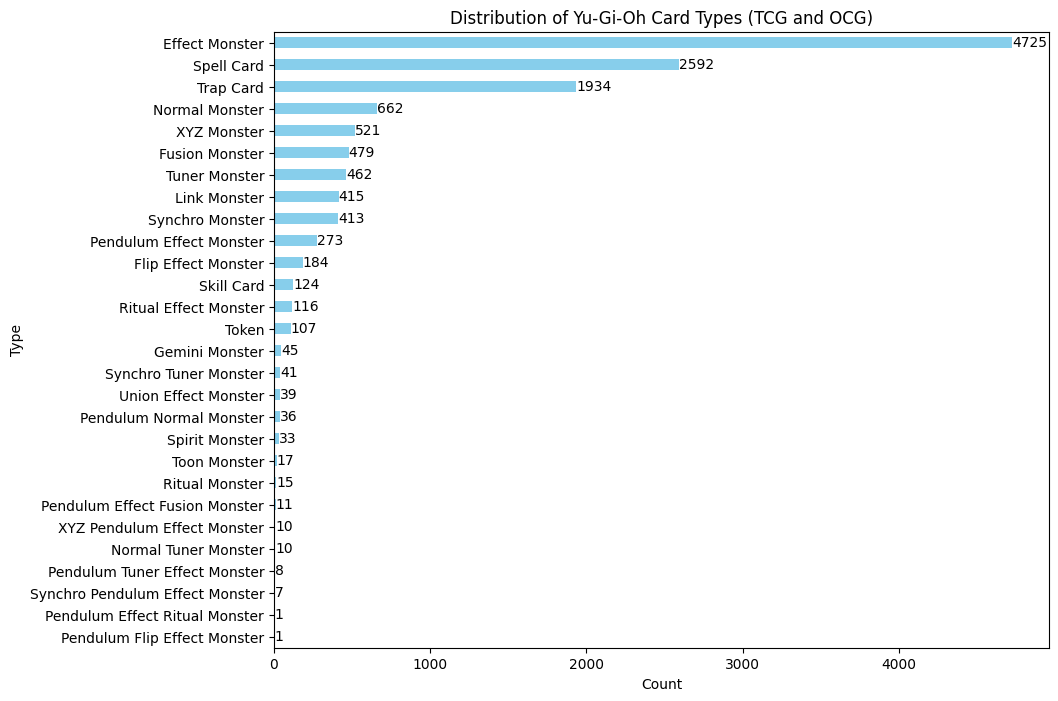

In [7]:
# Get the value counts for the 'type' column
type_counts = cards_data['type'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 8))
type_counts.sort_values().plot(kind='barh', color='skyblue')
# Add counts to the bars
for index, value in enumerate(type_counts.sort_values()):
    plt.text(value, index, str(value), va='center')  # `value` is the count, `index` is the bar position
plt.title('Distribution of Yu-Gi-Oh Card Types (TCG and OCG)')
plt.xlabel('Count')
plt.ylabel('Type')

In [8]:
cards_data['tcg_date'].dtype
print(cards_data['tcg_date'].head())

0    2007-05-16
1    2007-11-14
2    2016-11-03
3    2007-02-28
4    2023-07-27
Name: tcg_date, dtype: object


In [9]:
#Convert to the date format because the type of the column 'tcg_date' is object
cards_data['tcg_date_parsed']= pd.to_datetime(cards_data['tcg_date'], format= "%Y-%m-%d", errors="coerce")
cards_data['tcg_date_parsed'].head()

0   2007-05-16
1   2007-11-14
2   2016-11-03
3   2007-02-28
4   2023-07-27
Name: tcg_date_parsed, dtype: datetime64[ns]

In [10]:
#Convert to the date format because the type of the column 'ocg_date' is object
cards_data['ocg_date_parsed']= pd.to_datetime(cards_data['ocg_date'], format= "%Y-%m-%d",errors="coerce")
cards_data['ocg_date_parsed'].head()

0   2007-02-15
1   2007-07-21
2   2016-07-09
3   2006-11-16
4   2023-04-22
Name: ocg_date_parsed, dtype: datetime64[ns]

The Yu-Gi-Oh game and cards are separated into 2 categories depending on your location : TCG (Trading Card Game) and OCG (Original Card Game).
> OCG is played in asia (Japan, Korea, China and so on) while the TCG is played everywhere else (America, Europe and so on). (source: https://yugipedia.com/wiki/Forum:What_is_OCG_and_TCG%3F_whats_the_difference%3F)

In competitive spheres the rules and availability of the cards are different depending on TCG and OCG. This include cards that have become banned. 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


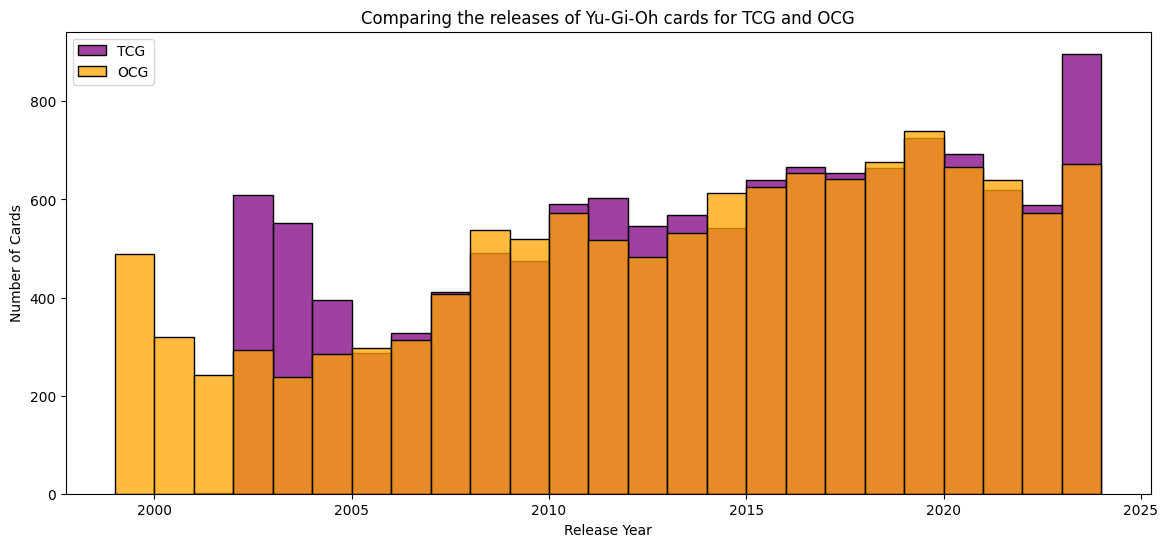

In [11]:
#Let's analyse the number of cards releases
cards_data["tcg_year"] = cards_data["tcg_date_parsed"].dt.year
cards_data["ocg_year"] = cards_data["ocg_date_parsed"].dt.year

cards_data = cards_data.dropna(subset=["tcg_year", "ocg_year"])
cards_data["tcg_year"] = cards_data["tcg_year"].astype(int)
cards_data["ocg_year"] = cards_data["ocg_year"].astype(int)

plt.figure(figsize=(14,6))
plt.title("Comparing the releases of Yu-Gi-Oh cards for TCG and OCG")
sns.histplot(cards_data["tcg_year"], color="purple", label="TCG", bins=range(cards_data["tcg_year"].min(), cards_data["tcg_year"].max() + 1) )
sns.histplot(cards_data["ocg_year"], color= "orange", label= "OCG", bins=range(cards_data["ocg_year"].min(), cards_data["ocg_year"].max() + 1))
plt.xlabel("Release Year")
plt.ylabel("Number of Cards")
plt.legend()
plt.show()

In [12]:
print("The earliest year a card was released on for the Original Card Game (OCG) was", int(cards_data["ocg_year"].min()),
      ", and the earliest year for the more international Trading Card Game (TCG) was",int(cards_data["tcg_year"].min()) ,"." )

The earliest year a card was released on for the Original Card Game (OCG) was 1999 , and the earliest year for the more international Trading Card Game (TCG) was 2001 .


> https://www.reddit.com/r/yugioh/comments/o6qbuy/the_wacky_timeline_of_early_yugioh_and_where/ 

In [13]:
tcg_2001=0
tcg_2002=0

for i in cards_data["tcg_year"]:
    if i ==2001:
        tcg_2001 +=1

for i in cards_data["tcg_year"]:
    if i ==2002:
        tcg_2002 +=1
        
print("The number of cards released during the first year of TCG was :", tcg_2001, "; and the second year :", tcg_2002, ".")
print("The first card released in 2001 for TCG was :" , cards_data.loc[cards_data["tcg_year"] == 2001, "name"].iloc[0])

print(cards_data.loc[cards_data["tcg_year"] == 2001, "formats"])

The number of cards released during the first year of TCG was : 1 ; and the second year : 609 .
The first card released in 2001 for TCG was : Summoned Skull
11002    GOAT|OCG GOAT|Duel Links|Common Charity|Speed ...
Name: formats, dtype: object


Why has only the card Summonned Skull been released in 2001 ?

After some research, I have found that it was first released as a sample promotional cards in 2001 for retailers in North America. https://yugipedia.com/wiki/Summoned_Skull https://yugipedia.com/wiki/Summoned_Skull_Sample_promotional_card

As we can see in the rest of the dataset, the launch of Yu-Gi-Oh for the TCG market really started in 2002.

I will consider that the promotional cards as regular cards since according to https://yugioh.fandom.com/wiki/Category:TCG_promotional_cards , there are only 84 items regarding the "promotional" term in search; and the sample cards are published later anyways.

# Are there more cards in TCG or OCG ?

In [14]:
#Total of cards
total_cards_tcg = cards_data['tcg_date_parsed'].value_counts().sum()
total_cards_ocg = cards_data['ocg_date_parsed'].value_counts().sum()

print("total_cards_tcg",total_cards_tcg,"total_cards_ocg",total_cards_ocg)

#Number of cards banned
total_ban_tcg = cards_data['ban_tcg'].value_counts().sum()
total_ban_ocg = cards_data['ban_ocg'].value_counts().sum()

print("total_ban_tcg",total_ban_tcg,"total_ban_ocg",total_ban_ocg)

#Usable cards in TCG vs OCG

usable_cards_tcg = total_cards_tcg - total_ban_tcg
usable_cards_ocg = total_cards_ocg - total_ban_ocg

print("usable_cards_tcg",usable_cards_tcg,"usable_cards_ocg",usable_cards_ocg)

total_cards_tcg 12542 total_cards_ocg 12542
total_ban_tcg 195 total_ban_ocg 190
usable_cards_tcg 12347 usable_cards_ocg 12352


To keep examining the differences between TCG and OCG, let's examine their ban lists to see if they coincide.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1057: FutureWarning: The default o

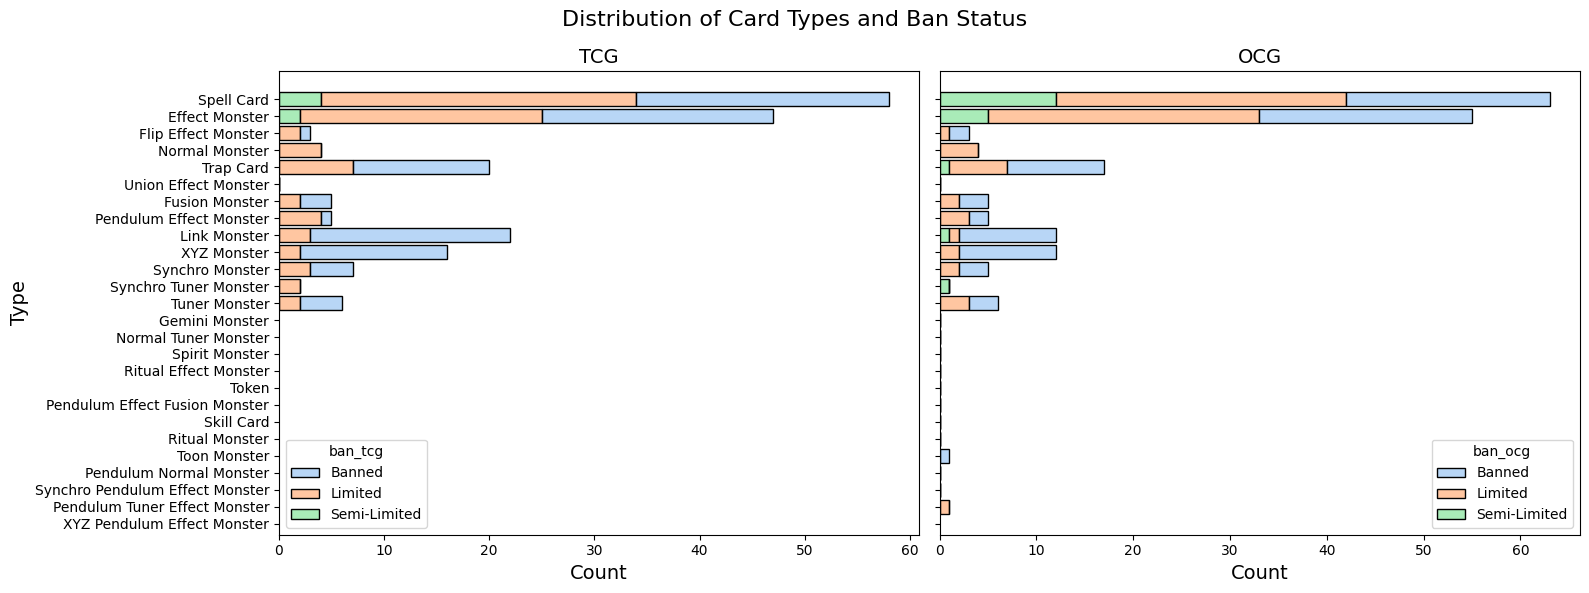

In [15]:
# Ensure 'ban_tcg' and 'ban_ocg' columns are categorical to avoid warnings
cards_data["ban_tcg"] = cards_data["ban_tcg"].astype("category")
cards_data["ban_ocg"] = cards_data["ban_ocg"].astype("category")


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Distribution of Card Types and Ban Status', ha = "center", fontsize=16)

ax = sns.histplot( data=cards_data, y='type', hue='ban_tcg', multiple='stack', shrink=0.8, palette='pastel',ax=axes[0] ) # Specify which subplot to draw on

#for container in ax.containers:
#    ax.bar_label(container, fmt='%d', fontsize=8)

ax.set_title("TCG", fontsize=14)
ax.set_xlabel("Count", fontsize=14)
ax.set_ylabel("Type", fontsize=14)

ax_a = sns.histplot( data=cards_data, y='type', hue='ban_ocg', multiple='stack', shrink=0.8, palette='pastel', ax=axes[1])  # Specify which subplot to draw on 

#for container in ax_a.containers:
#    ax_a.bar_label(container, fmt='%d', fontsize=8)

ax_a.set_title("OCG", fontsize=14)
ax_a.set_xlabel("Count", fontsize=14)
ax_a.set_ylabel("")  # Remove redundant y-axis label

plt.tight_layout()

plt.show()

<ipython-input-16-0b53e8fcb1b8>:12: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax_1 = sns.histplot(data=banned_tcg_data, y='type', hue='ban_tcg', multiple='stack', shrink=0.8, palette = ['orange'],ax=axes[0], legend=False ) # Specify which subplot to draw on
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py

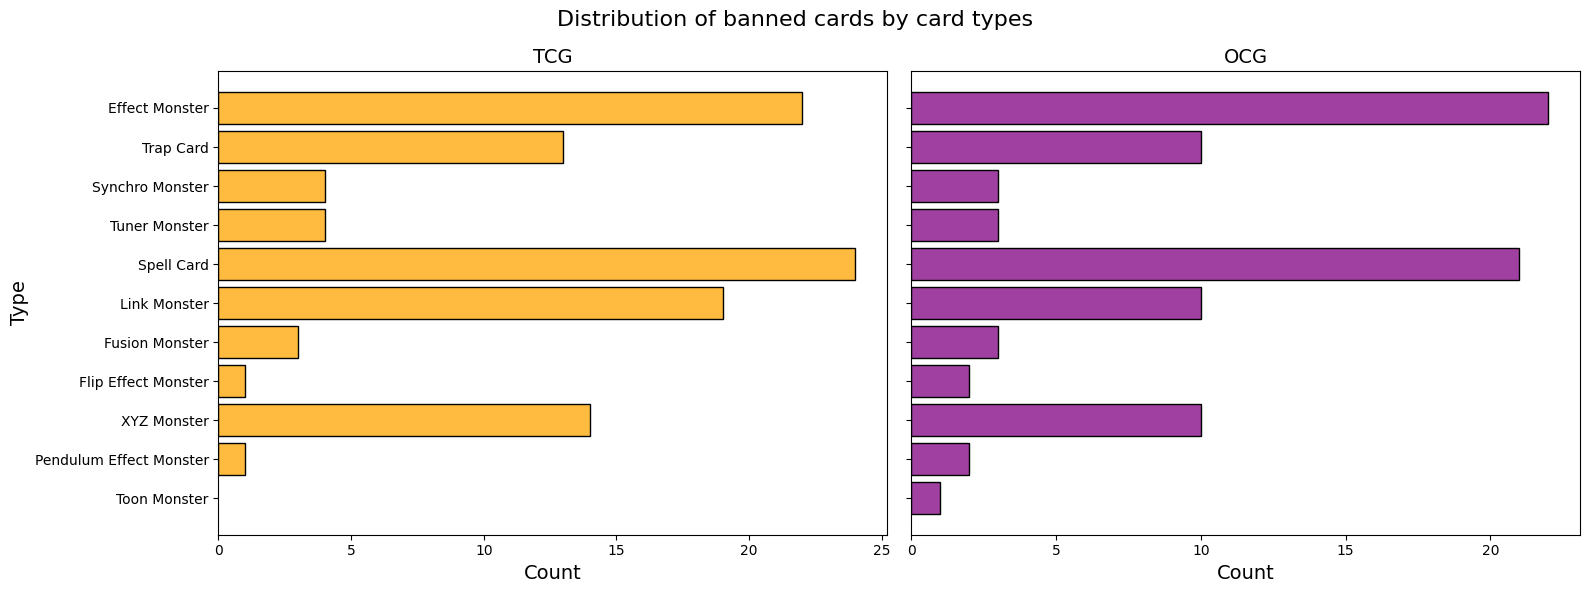

In [16]:
# Ensure 'ban_tcg' and 'ban_ocg' columns are categorical to avoid warnings
cards_data["ban_tcg"] = cards_data["ban_tcg"].astype("category")
cards_data["ban_ocg"] = cards_data["ban_ocg"].astype("category")

banned_tcg_data = cards_data[cards_data["ban_tcg"] == "Banned"]
banned_ocg_data = cards_data[cards_data["ban_ocg"] == "Banned"]


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Distribution of banned cards by card types', ha = "center", fontsize=16)

ax_1 = sns.histplot(data=banned_tcg_data, y='type', hue='ban_tcg', multiple='stack', shrink=0.8, palette = ['orange'],ax=axes[0], legend=False ) # Specify which subplot to draw on

#for container in ax.containers:
#    ax.bar_label(container, fmt='%d', fontsize=8)

ax_1.set_title("TCG", fontsize=14)
ax_1.set_xlabel("Count", fontsize=14)
ax_1.set_ylabel("Type", fontsize=14)

ax_2 = sns.histplot(data=banned_ocg_data, y='type', hue='ban_ocg', multiple='stack', shrink=0.8, palette = ['purple'], ax=axes[1],legend=False)  # Specify which subplot to draw on 

#for container in ax_a.containers:
#    ax_a.bar_label(container, fmt='%d', fontsize=8)

ax_2.set_title("OCG", fontsize=14)
ax_2.set_xlabel("Count", fontsize=14)
ax_2.set_ylabel("")  # Remove redundant y-axis label

plt.tight_layout()

plt.show()

We are going to analyse the cards historically :
- How many cards are authorized at a given time ? /ban lists
    - difference TNG and OCG
- What are the trends in type of monsters ?
        - race 
        - attribute
        - levels 
        - def
        - atk
        - has effect ?
- More information on the banned cards

And we are going to investigate the special effect chains which are supposed to have changed the game from its origins:
- Is the the use of semicolons correlated to the lengths of the description of the card ?
- Is the the use of semicolons correlated to the possible effect of the card ?
- Chain keywords in the game + has effect
- Bulletpoint use

According to Wikipedia, this is the definition of Chains in the Yu-Gi-Oh game :

A chain is a stack of card effects activated one after the other. It exists for the management of multiple card effects.

A chain is created when the effects of more than one card are activated at the same time, or when a player activates an effect after a card is played, but before the card impacts the game.

If the effect of a card is activated, the opponent always has the possibility to reply with an effect of their own cards, thus creating a chain.

If your opponent replied with an effect, you can choose to reply back and add another effect to the chain. If your opponent chooses not to reply, you can add a second effect and create a chain off of the activation of your own card. Each player can then continue to add effects to the chain. The chain ends when the players wish to not play any more cards. Should this happen, the chain is resolved: the resolution is performed in reverse order of play, starting with the effect of the most recently played card.

It is advised to not resolve card effects before ensuring that a chain had not been created.